20200805

Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We would like to compute the aperture correction for HST grism extraction when performing on a drz-blot flt frame.

# Background
Aperture correction for original flt frame of HST grisms was presented in ISRs. However, this correction might not be the same when the reduction is performed on a drz-blot flt frame. Theoretically, we would expect drz-blot flt objects to have different PSFs. Therefore, additional correction should be necessary when performing grism reduction on drz-blot flt frame.

# Previously...
- 20200803_02: With GD153, it is promising that we would get a good quality of aperture correction. To proceed from this:
    - Specify extraction aperture width (i.e., halfdy = 3,4,5)
    - Collect the cps given wavelength (or a set of wavelength, i.e., boxcar) from
     - 4 flatflt images, and average
     - 1 drzblot
    - Ratio between drzblot/flatflt given wavelength
    - Since drzblot has wider line spread function, we would expect the ratio < 1.
    - Note: be careful when performing background subtraction that both drzblot and flatflt images are set to the same background level.
    
# Resources:
- Files from 20200803, GD153 for i) drzblot image, ii) four flatflt images, and iii) backgrounds,
- hstgrism.objectmask.ObjectMask to facilitate making masks with different aperture widths.

# Objectives
- Derive aperture correction comparing between drzblot and flatflt.
- Apply the correction to GRB 190829A.

# Tasks:
- Compute drzblot aperture correction (dbapcorr) as drzblot/average(flatflt | 4 flatflt images) given wavelength and aperture width.
- Verify whether this correction by:
 - Complete extraction of GD153 in drzblot image without applying dbapcorr.
 - Apply dbapcorr.
 - Compare with the calspec.
- Verify if this example is suitable to be applied with GRB 190829A. If not, find a dataset that is suitable for.

# Notes:
- flatflt: To minimize problems with bad pixels, let's use CR corr files from drizzle.
 

In [159]:
from astropy.io import fits

def bkgsub(gfile,bfile,container,savesuffix = 'sub'):
    savefolder = container.data['savefolder']
    saveprefix = container.data['saveprefix']
    gdata = fits.open(gfile[0])[gfile[1]].data
    bdata = fits.open(bfile[0])[bfile[1]].data
    sdata = gdata - bdata
    phdu = fits.PrimaryHDU()
    ihdu = fits.ImageHDU()
    hdul = fits.HDUList([phdu,ihdu])
    hdul[1].data = sdata
    string = './{0}/{1}_{2}.fits'.format(savefolder,saveprefix,savesuffix)
    hdul.writeto(string,overwrite=True)
    print('Save {0}'.format(string))
    

In [160]:
from hstgrism.container import Container
from hstgrism.confreader import ConfReader
from hstgrism.computesip import ComputeSIP
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg102 import WFC3IRG102
from hstgrism.cutout2d import Cutout2D
from hstgrism.objectmask import ObjectMask
from hstgrism.flatfield import FlatField
from hstgrism.background import Background
from hstgrism.to_fullframe import to_fullframe
from hstgrism.grismapcorr import GrismApCorr
from hstgrism.show_overview import show_overview
from hstgrism.show_bbox import show_bbox
from hstgrism.show_sum1d import show_sum1d
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import copy,glob


# 1. drzblot
Note: already did flatfield

## 1.1. trace, wavelength, bkg

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder drzblot_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./drzblot_GD153/drzblot_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./drzblot_GD153/drzblot_GD153_trace.csv
Save ./drzblot_GD153/drzblot_GD153_tbox.csv
Save ./drzblot_GD153/drzblot_GD153_bbox.csv
Save ./drzblot_GD153/drzblot_GD153_bbcorner.csv
Save ./drzblot_GD153/drzblot_GD153_cutout.fits
Save ./drzblot_GD153/drzblot_GD153_mask.fits
Save ./drzblot_GD153/drzblot_GD153_overview.pdf



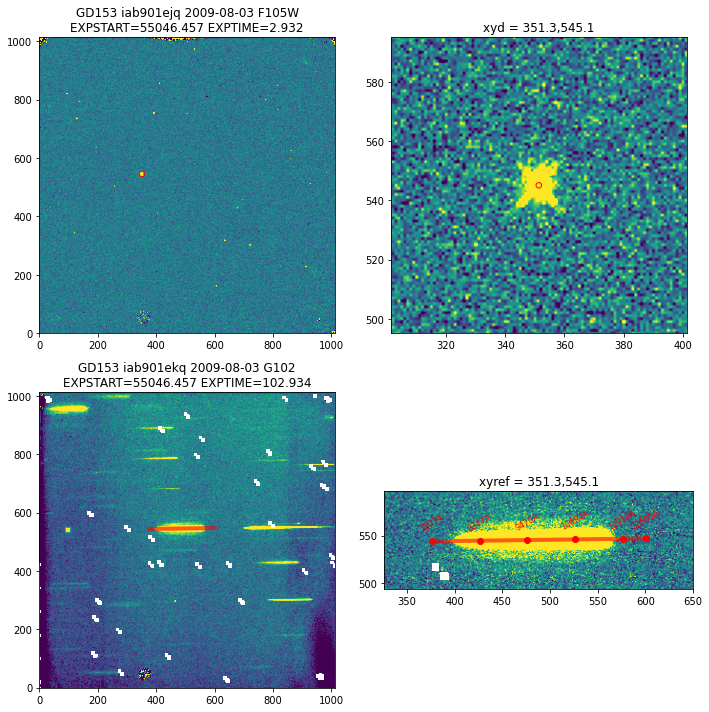

In [161]:
gfile = ('../20200803/drzblot_GD153/iab901ekq_flt.fits',1)
confile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/G102.F105W.V4.32.conf'
beam = 'A'
dfile = ('/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/HST/iab901ejq/iab901ejq_flt.fits',1) # file and extension
xyd = (351.32706,545.13459)

saveprefix = 'drzblot_GD153'
savefolder = 'drzblot_GD153'
plotformat = 'pdf'
overwrite = False
container_params = {'saveprefix':saveprefix,
                    'savefolder':savefolder,
                    'plotformat':plotformat,
                    'overwrite':overwrite
                   }
containerobj = Container(**container_params)

##########
# Compute xyref
##########
xyref_params = {'xyd':xyd,
                'xydiff':'default',
                'xyoff':'default',
                'confile':confile,
                'beam':beam,
                'gfile':gfile,
                'dfile':dfile,
                'container':containerobj
               }
xyrefobj = ComputeXYREF(**xyref_params)
xyrefobj.compute()
xyrefobj.save()
##########
# Map trace and wavelength
##########
xyref = xyrefobj.data['xyref']
grism_params = {'confile':confile,
                'beam':beam,
                'xyref':xyref,
                'container':containerobj
               }
grismobj = WFC3IRG102(**grism_params)
grismobj.compute()
grismobj.save()
##########
# Make cutout
##########
tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
tdata = pd.read_csv(tfile)
xg = tdata.xh + tdata.xyref[0]
yg = tdata.yh + tdata.xyref[1]
halfdy = 20
tbox = {'xg':xg,'yg':yg,'halfdyup':halfdy,'halfdylow':halfdy}
bbox={'padxleft': 15, 'padxright': 15, 'padyup': 15, 'padylow': 15}
image = fits.open(gfile[0])[gfile[1]].data
do_mask = True
cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
cutoutobj.compute(do_mask)
cutoutobj.save()
##########
# show_overview
##########
show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
              objname='GD153',
              save=True,
              container=containerobj,
             )


Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,254.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,73.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 65 invalid data points
data_minmax = (0.9016947746276855,159.23306274414062) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./drzblot_GD153/drzblot_GD153_cutbkg.fits
Save ./drzblot_GD153/drzblot_GD153_maskfit.fits
Save ./drzblot_GD153/drzblot_GD153_sub.fits


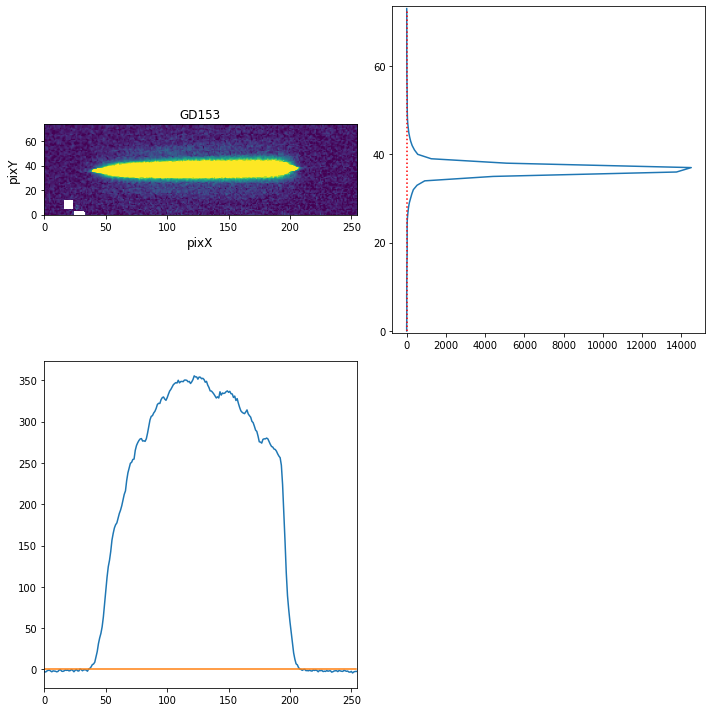

In [162]:
##########
# Background estimation
##########
sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
mfile = ('./{0}/{1}_mask.fits'.format(sfolder,sprefix),1)
gdata = fits.open(gfile[0])[gfile[1]].data
mdata = fits.open(mfile[0])[mfile[1]].data.astype(bool)
norder = 0
sigclip=(False, 5, 1.)
bkgobj = Background(gdata=gdata,norder=norder,mdata=mdata,sigclip=sigclip,container=containerobj)
bkgobj.poly2d.fit()
bkgobj.save(do_yfit=True,do_maskfit=True)
##########
# bkg sub
##########
sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
bfile = ('./{0}/{1}_cutbkg.fits'.format(sfolder,sprefix),1)
bkgsub(gfile,bfile,containerobj)
##########
# show_sum1d
##########
sfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
tmpdata = fits.open(sfile[0])[sfile[1]].data
show_sum1d(gdata=tmpdata,objname='GD153',mdata=None,do_zero=True,save=False,container=None)


## 1.2. Extraction
- make mask with different aperture width
- extract

Save ./drzblot_GD153/drzblot_GD153_halfdy0_mask.fits
Save ./drzblot_GD153/drzblot_GD153_halfdy1_mask.fits
Save ./drzblot_GD153/drzblot_GD153_halfdy2_mask.fits
Save ./drzblot_GD153/drzblot_GD153_halfdy3_mask.fits
Save ./drzblot_GD153/drzblot_GD153_halfdy4_mask.fits
Save ./drzblot_GD153/drzblot_GD153_halfdy5_mask.fits
Save ./drzblot_GD153/drzblot_GD153_halfdy6_mask.fits
Save ./drzblot_GD153/drzblot_GD153_halfdy7_mask.fits
Save ./drzblot_GD153/drzblot_GD153_halfdy8_mask.fits
Save ./drzblot_GD153/drzblot_GD153_halfdy9_mask.fits
Save ./drzblot_GD153/drzblot_GD153_halfdy10_mask.fits
Save ./drzblot_GD153/drzblot_GD153_halfdy15_mask.fits
Save ./drzblot_GD153/drzblot_GD153_halfdy20_mask.fits
Save ./drzblot_GD153/drzblot_GD153_halfdy0_cps.csv
Save ./drzblot_GD153/drzblot_GD153_halfdy1_cps.csv
Save ./drzblot_GD153/drzblot_GD153_halfdy2_cps.csv
Save ./drzblot_GD153/drzblot_GD153_halfdy3_cps.csv
Save ./drzblot_GD153/drzblot_GD153_halfdy4_cps.csv
Save ./drzblot_GD153/drzblot_GD153_halfdy5_cps.csv
Sa

Text(0.5, 1.0, 'drzblot')

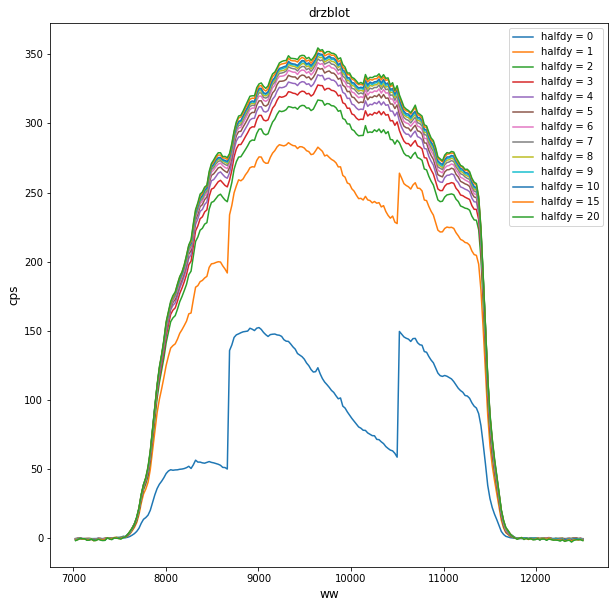

In [163]:
##########
# make mask
##########
halfdy = [0,1,2,3,4,5,6,7,8,9,10,15,20]
sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
gfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
gdata = fits.open(gfile[0])[gfile[1]]
ny,nx = gdata.shape
trace = './{0}/{1}_trace.csv'.format(sfolder,sprefix)
trace = pd.read_csv(trace)
bbcorner = './{0}/{1}_bbcorner.csv'.format(sfolder,sprefix)
bbcorner = pd.read_csv(bbcorner)
tx = trace.xh + trace.xyref[0] - bbcorner.bb0x[0] 
ty = trace.yh + trace.xyref[1] - bbcorner.bb0y[0]
for i,ii in enumerate(halfdy):
    t = ObjectMask(nx,ny,tx,ty,halfdy[i],halfdy[i])
    t.compute()
    tmpcont = copy.deepcopy(containerobj)
    tmpcont.data['saveprefix'] += '_halfdy{0}'.format(halfdy[i])
    t.save(tmpcont)
#     plt.figure(),plt.imshow(t.mask,origin='lower')

##########
# Extraction
##########
for i,ii in enumerate(halfdy):
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    gfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
    mfile = ('./{0}/{1}_halfdy{2}_mask.fits'.format(sfolder,sprefix,halfdy[i]),1)
    bbox = pd.read_csv('./{0}/{1}_bbox.csv'.format(sfolder,sprefix))
    trace = pd.read_csv('./{0}/{1}_trace.csv'.format(sfolder,sprefix))
    tbox = pd.read_csv('./{0}/{1}_tbox.csv'.format(sfolder,sprefix))
    instrument = 'HST-WFC3-IR-G102'
    ww = trace.ww.values
    xh = trace.xh.values
    cps = fits.open(gfile[0])[gfile[1]].data
    cps *= fits.open(mfile[0])[mfile[1]].data
    cps = np.nansum(cps,axis=0)[bbox.padxleft[0]:-bbox.padxright[0]]
    output = {'ww':ww,'cps':cps}
    string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
    pd.DataFrame(output).to_csv(string)
    print('Save {0}'.format(string))
    
##########
# show_cps
##########
plt.figure(figsize=(10,10))
for i,ii in enumerate(halfdy):
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
    t = pd.read_csv(string)
    plt.plot(t.ww,t.cps,label='halfdy = {0}'.format(halfdy[i]))
plt.legend()
plt.xlabel('ww',fontsize=12)
plt.ylabel('cps',fontsize=12)
plt.title('drzblot',fontsize=12)

    

# 2. crcorr

In [164]:
crcorrfile = glob.glob('../20200803/*GD153/*crclean.fits')
crcorrfile

['../20200803/iab901elq_GD153/iab901elq_crclean.fits',
 '../20200803/iab901enq_GD153/iab901enq_crclean.fits',
 '../20200803/iab901emq_GD153/iab901emq_crclean.fits',
 '../20200803/iab901ekq_GD153/iab901ekq_crclean.fits']

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901elq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./iab901elq_GD153/iab901elq_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./iab901elq_GD153/iab901elq_GD153_trace.csv
Save ./iab901elq_GD153/iab901elq_GD153_tbox.csv
Save ./iab901elq_GD153/iab901elq_GD153_bbox.csv
Save ./iab901elq_GD153/iab901elq_GD153_bbcorner.csv
Save ./iab901elq_GD153/iab901elq_GD153_cutout.fits
Save ./iab901elq_GD153/iab901elq_GD153_mask.fits
Save ./iab901elq_GD153/iab901elq_GD153_overview.pdf

Save ./iab901enq_GD153/iab901enq_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./iab901enq_GD153/iab901enq_GD153_trace.csv
Save ./iab901enq_GD153/iab901enq_GD153_tbox.csv
Save ./iab901enq_GD153/iab901enq_GD153_bbox.csv
Save ./iab901enq_GD153/iab901enq_GD153_bbcorner.csv
Save ./iab901enq_GD153/iab901enq_GD153_cutout.fits
Save ./iab901enq_GD153/iab901enq_GD153_mask.fits

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901enq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./iab901enq_GD153/iab901enq_GD153_overview.pdf

Save ./iab901emq_GD153/iab901emq_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./iab901emq_GD153/iab901emq_GD153_trace.csv
Save ./iab901emq_GD153/iab901emq_GD153_tbox.csv
Save ./iab901emq_GD153/iab901emq_GD153_bbox.csv
Save ./iab901emq_GD153/iab901emq_GD153_bbcorner.csv
Save ./iab901emq_GD153/iab901emq_GD153_cutout.fits
Save ./iab901emq_GD153/iab901emq_GD153_mask.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901emq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./iab901emq_GD153/iab901emq_GD153_overview.pdf

Save ./iab901ekq_GD153/iab901ekq_GD153_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./iab901ekq_GD153/iab901ekq_GD153_trace.csv
Save ./iab901ekq_GD153/iab901ekq_GD153_tbox.csv
Save ./iab901ekq_GD153/iab901ekq_GD153_bbox.csv
Save ./iab901ekq_GD153/iab901ekq_GD153_bbcorner.csv
Save ./iab901ekq_GD153/iab901ekq_GD153_cutout.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_mask.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901ekq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./iab901ekq_GD153/iab901ekq_GD153_overview.pdf



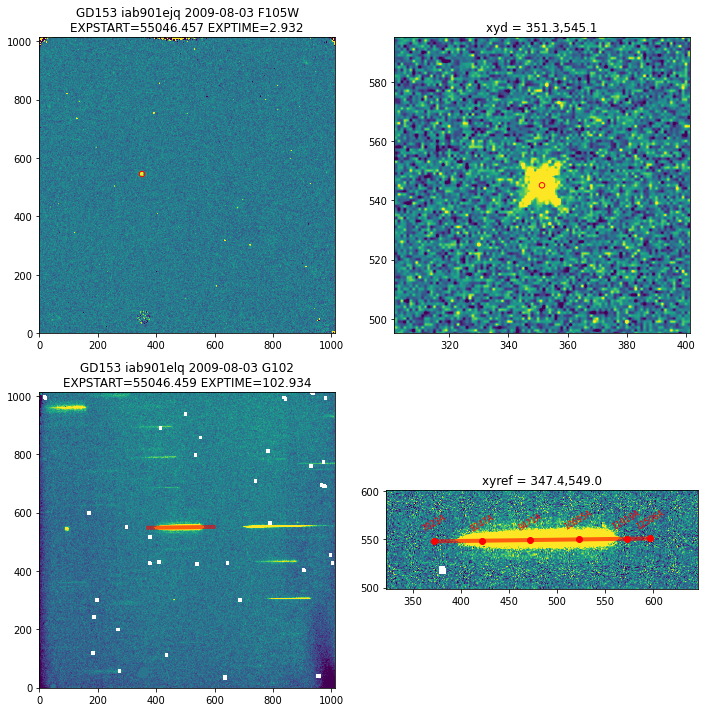

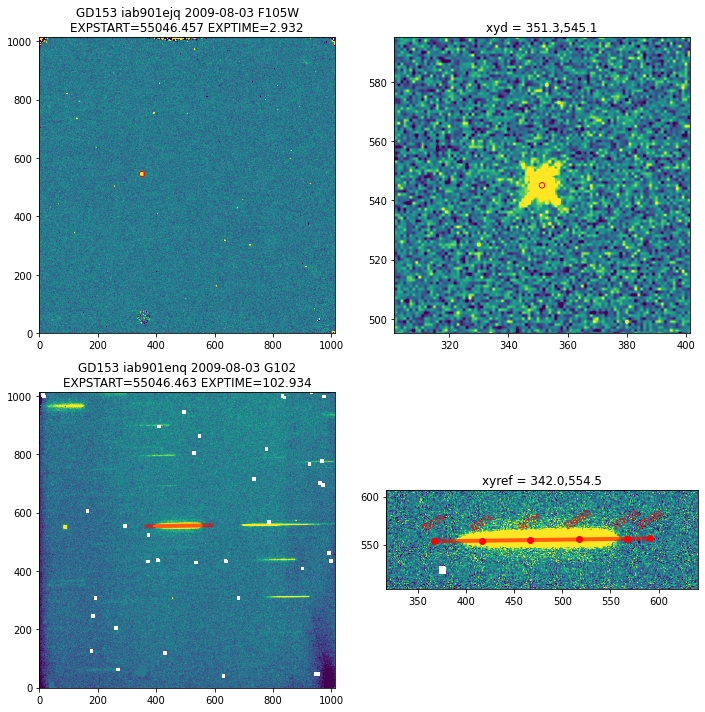

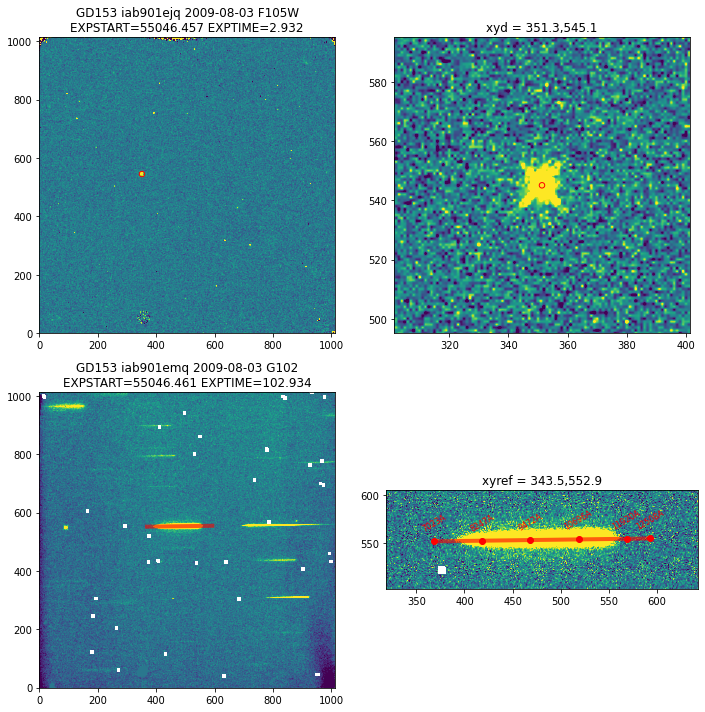

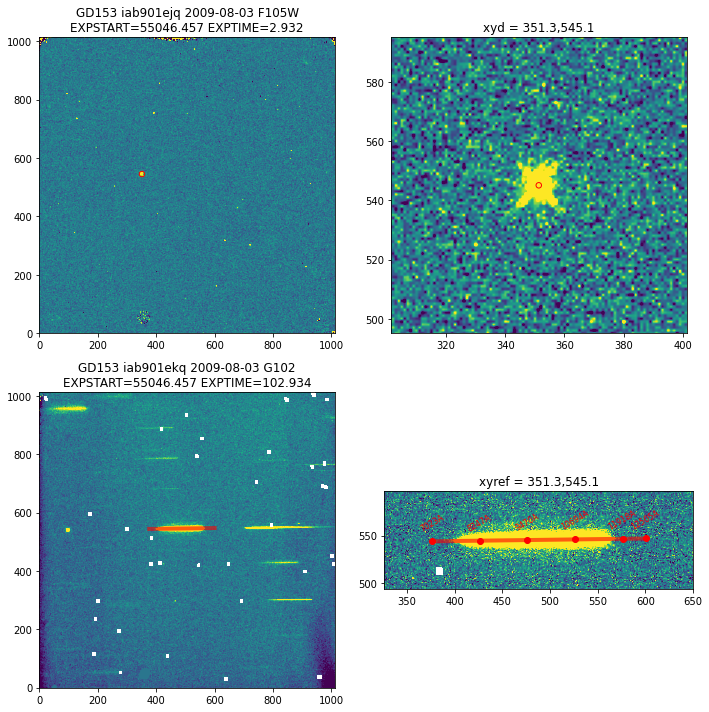

In [165]:
for i,ii in enumerate(crcorrfile):
    gfile = (crcorrfile[i],1)
    confile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/G102.F105W.V4.32.conf'
    beam = 'A'
    dfile = ('/Users/kbhirombhakdi/_work/_data/11552/G102_set/mastDownload/HST/iab901ejq/iab901ejq_flt.fits',1) # file and extension
    xyd = (351.32706,545.13459)

    saveprefix = '{0}_GD153'.format(crcorrfile[i].split('/')[-1].split('_')[0])
    savefolder = saveprefix
    plotformat = 'pdf'
    overwrite = False
    container_params = {'saveprefix':saveprefix,
                        'savefolder':savefolder,
                        'plotformat':plotformat,
                        'overwrite':overwrite
                       }
    containerobj = Container(**container_params)

    ##########
    # Compute xyref
    ##########
    xyref_params = {'xyd':xyd,
                    'xydiff':'default',
                    'xyoff':'default',
                    'confile':confile,
                    'beam':beam,
                    'gfile':gfile,
                    'dfile':dfile,
                    'container':containerobj
                   }
    xyrefobj = ComputeXYREF(**xyref_params)
    xyrefobj.compute()
    xyrefobj.save()
    ##########
    # Map trace and wavelength
    ##########
    xyref = xyrefobj.data['xyref']
    grism_params = {'confile':confile,
                    'beam':beam,
                    'xyref':xyref,
                    'container':containerobj
                   }
    grismobj = WFC3IRG102(**grism_params)
    grismobj.compute()
    grismobj.save()
    ##########
    # Make cutout
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    xg = tdata.xh + tdata.xyref[0]
    yg = tdata.yh + tdata.xyref[1]
    halfdy = 20
    tbox = {'xg':xg,'yg':yg,'halfdyup':halfdy,'halfdylow':halfdy}
    bbox={'padxleft': 15, 'padxright': 15, 'padyup': 15, 'padylow': 15}
    image = fits.open(gfile[0])[gfile[1]].data
    do_mask = True
    cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
    cutoutobj.compute(do_mask)
    cutoutobj.save()
    ##########
    # show_overview
    ##########
    show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
                  objname='GD153',
                  save=True,
                  container=containerobj,
                 )


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901elq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901enq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,254.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,72.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 54 invalid data points
data_minmax = (0.22373667359352112,179.2872772216797) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./iab901elq_GD153/iab901elq_GD153_cutbkg.fits
Save ./iab901elq_GD153/iab901elq_GD153_maskfit.fits
Save ./iab901elq_GD153/iab901elq_GD153_sub.fits
Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,254.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,73.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 41 invalid data points
data_minmax = (0.29307812452316284,184.01776123046875) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./iab

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901emq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901ekq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,254.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,73.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 41 invalid data points
data_minmax = (0.5621737241744995,177.79750061035156) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./iab901ekq_GD153/iab901ekq_GD153_cutbkg.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_maskfit.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_sub.fits


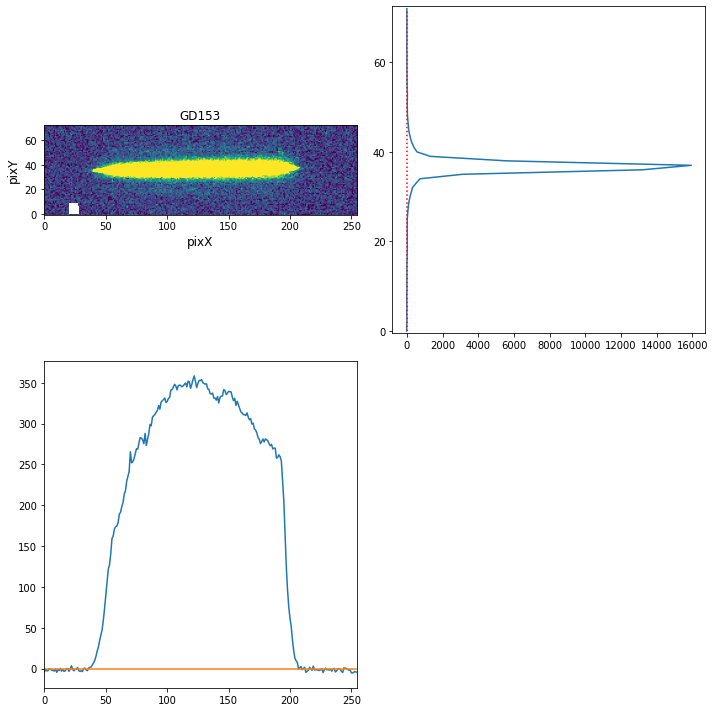

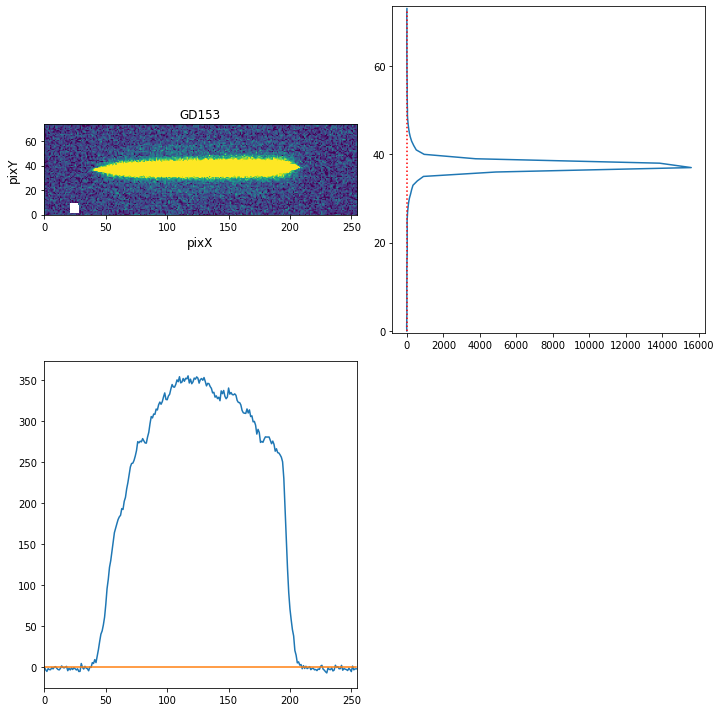

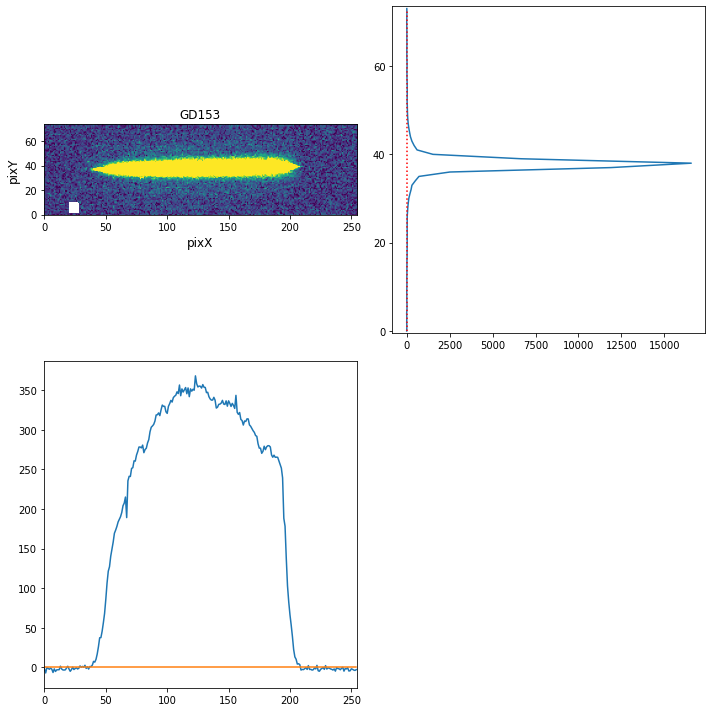

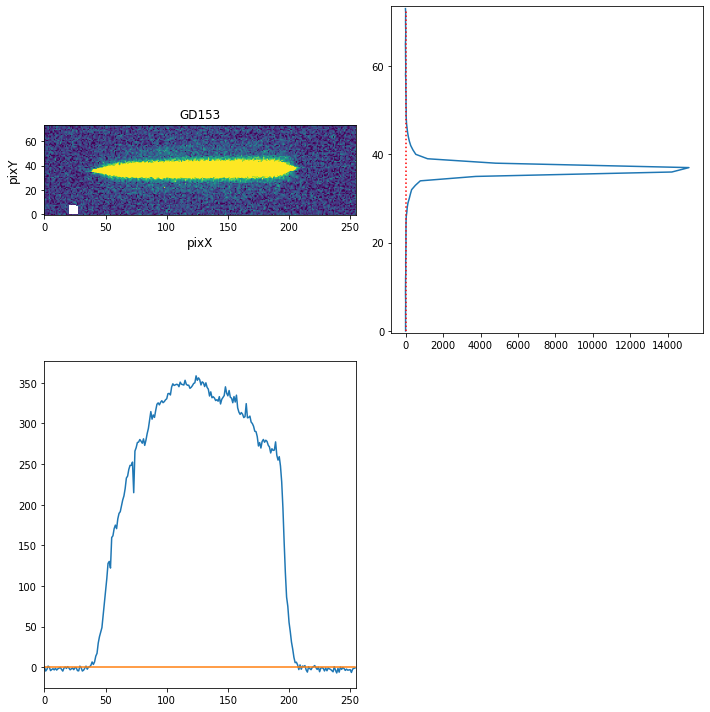

In [166]:
##########
# Background estimation
##########
for i,ii in enumerate(crcorrfile):
    saveprefix = '{0}_GD153'.format(crcorrfile[i].split('/')[-1].split('_')[0])
    savefolder = saveprefix
    plotformat = 'pdf'
    overwrite = False
    containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
    mfile = ('./{0}/{1}_mask.fits'.format(sfolder,sprefix),1)
    gdata = fits.open(gfile[0])[gfile[1]].data
    mdata = fits.open(mfile[0])[mfile[1]].data.astype(bool)
    norder = 0
    sigclip=(False, 5, 1.)
    bkgobj = Background(gdata=gdata,norder=norder,mdata=mdata,sigclip=sigclip,container=containerobj)
    bkgobj.poly2d.fit()
    bkgobj.save(do_yfit=True,do_maskfit=True)
    ##########
    # bkg sub
    ##########
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
    bfile = ('./{0}/{1}_cutbkg.fits'.format(sfolder,sprefix),1)
    bkgsub(gfile,bfile,containerobj)
    ##########
    # show_sum1d
    ##########
    sfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
    tmpdata = fits.open(sfile[0])[sfile[1]].data
    show_sum1d(gdata=tmpdata,objname='GD153',mdata=None,do_zero=True,save=False,container=None)


In [167]:
##########
# make mask
##########
halfdy = [0,1,2,3,4,5,6,7,8,9,10,15,20]
for i,ii in enumerate(crcorrfile):
    saveprefix = '{0}_GD153'.format(crcorrfile[i].split('/')[-1].split('_')[0])
    savefolder = saveprefix
    plotformat = 'pdf'
    overwrite = False
    containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    gfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
    gdata = fits.open(gfile[0])[gfile[1]]
    ny,nx = gdata.shape
    trace = './{0}/{1}_trace.csv'.format(sfolder,sprefix)
    trace = pd.read_csv(trace)
    bbcorner = './{0}/{1}_bbcorner.csv'.format(sfolder,sprefix)
    bbcorner = pd.read_csv(bbcorner)
    tx = trace.xh + trace.xyref[0] - bbcorner.bb0x[0] 
    ty = trace.yh + trace.xyref[1] - bbcorner.bb0y[0]
    for j,jj in enumerate(halfdy):
        t = ObjectMask(nx,ny,tx,ty,halfdy[j],halfdy[j])
        t.compute()
        tmpcont = copy.deepcopy(containerobj)
        tmpcont.data['saveprefix'] += '_halfdy{0}'.format(halfdy[j])
        t.save(tmpcont)
#         plt.figure(),plt.imshow(t.mask,origin='lower')


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901elq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901enq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./iab901elq_GD153/iab901elq_GD153_halfdy0_mask.fits
Save ./iab901elq_GD153/iab901elq_GD153_halfdy1_mask.fits
Save ./iab901elq_GD153/iab901elq_GD153_halfdy2_mask.fits
Save ./iab901elq_GD153/iab901elq_GD153_halfdy3_mask.fits
Save ./iab901elq_GD153/iab901elq_GD153_halfdy4_mask.fits
Save ./iab901elq_GD153/iab901elq_GD153_halfdy5_mask.fits
Save ./iab901elq_GD153/iab901elq_GD153_halfdy6_mask.fits
Save ./iab901elq_GD153/iab901elq_GD153_halfdy7_mask.fits
Save ./iab901elq_GD153/iab901elq_GD153_halfdy8_mask.fits
Save ./iab901elq_GD153/iab901elq_GD153_halfdy9_mask.fits
Save ./iab901elq_GD153/iab901elq_GD153_halfdy10_mask.fits
Save ./iab901elq_GD153/iab901elq_GD153_halfdy15_mask.fits
Save ./iab901elq_GD153/iab901elq_GD153_halfdy20_mask.fits
Save ./iab901enq_GD153/iab901enq_GD153_halfdy0_mask.fits
Save ./iab901enq_GD153/iab901enq_GD153_halfdy1_mask.fits
Save ./iab901enq_GD153/iab901enq_GD153_halfdy2_mask.fits
Save ./iab901enq_GD153/iab901enq_GD153_halfdy3_mask.fits
Save ./iab901enq_GD153/iab90

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901emq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901ekq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./iab901emq_GD153/iab901emq_GD153_halfdy5_mask.fits
Save ./iab901emq_GD153/iab901emq_GD153_halfdy6_mask.fits
Save ./iab901emq_GD153/iab901emq_GD153_halfdy7_mask.fits
Save ./iab901emq_GD153/iab901emq_GD153_halfdy8_mask.fits
Save ./iab901emq_GD153/iab901emq_GD153_halfdy9_mask.fits
Save ./iab901emq_GD153/iab901emq_GD153_halfdy10_mask.fits
Save ./iab901emq_GD153/iab901emq_GD153_halfdy15_mask.fits
Save ./iab901emq_GD153/iab901emq_GD153_halfdy20_mask.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_halfdy0_mask.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_halfdy1_mask.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_halfdy2_mask.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_halfdy3_mask.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_halfdy4_mask.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_halfdy5_mask.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_halfdy6_mask.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_halfdy7_mask.fits
Save ./iab901ekq_GD153/iab901ekq_GD153_halfdy8_mask.fits
Save ./iab901ekq_GD153/iab90

Save ./iab901elq_GD153/iab901elq_GD153_halfdy0_cps.csv
Save ./iab901elq_GD153/iab901elq_GD153_halfdy1_cps.csv
Save ./iab901elq_GD153/iab901elq_GD153_halfdy2_cps.csv
Save ./iab901elq_GD153/iab901elq_GD153_halfdy3_cps.csv
Save ./iab901elq_GD153/iab901elq_GD153_halfdy4_cps.csv
Save ./iab901elq_GD153/iab901elq_GD153_halfdy5_cps.csv
Save ./iab901elq_GD153/iab901elq_GD153_halfdy6_cps.csv
Save ./iab901elq_GD153/iab901elq_GD153_halfdy7_cps.csv
Save ./iab901elq_GD153/iab901elq_GD153_halfdy8_cps.csv
Save ./iab901elq_GD153/iab901elq_GD153_halfdy9_cps.csv
Save ./iab901elq_GD153/iab901elq_GD153_halfdy10_cps.csv
Save ./iab901elq_GD153/iab901elq_GD153_halfdy15_cps.csv
Save ./iab901elq_GD153/iab901elq_GD153_halfdy20_cps.csv
Save ./iab901enq_GD153/iab901enq_GD153_halfdy0_cps.csv
Save ./iab901enq_GD153/iab901enq_GD153_halfdy1_cps.csv
Save ./iab901enq_GD153/iab901enq_GD153_halfdy2_cps.csv
Save ./iab901enq_GD153/iab901enq_GD153_halfdy3_cps.csv
Save ./iab901enq_GD153/iab901enq_GD153_halfdy4_cps.csv
Save ./

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901elq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901elq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901elq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901elq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901elq_GD153 al

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901ekq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901ekq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901ekq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901ekq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901ekq_GD153 al

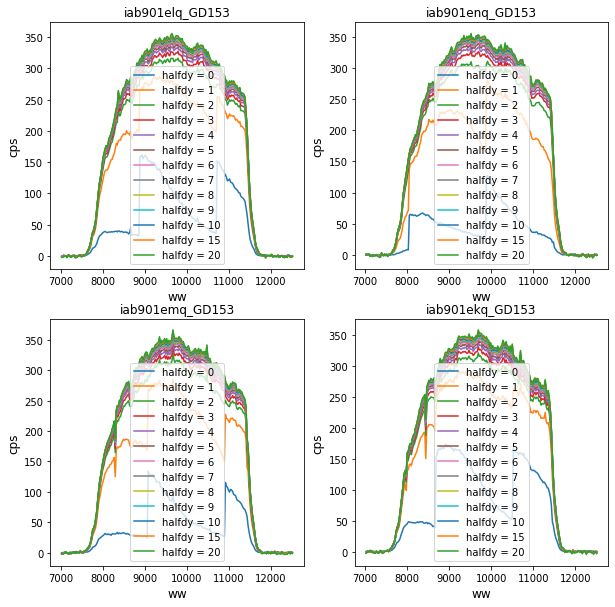

In [168]:
##########
# Extraction
##########
halfdy = [0,1,2,3,4,5,6,7,8,9,10,15,20]
for j,jj in enumerate(crcorrfile):
    for i,ii in enumerate(halfdy):
        saveprefix = '{0}_GD153'.format(crcorrfile[j].split('/')[-1].split('_')[0])
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
        sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
        gfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
        mfile = ('./{0}/{1}_halfdy{2}_mask.fits'.format(sfolder,sprefix,halfdy[i]),1)
        bbox = pd.read_csv('./{0}/{1}_bbox.csv'.format(sfolder,sprefix))
        trace = pd.read_csv('./{0}/{1}_trace.csv'.format(sfolder,sprefix))
        tbox = pd.read_csv('./{0}/{1}_tbox.csv'.format(sfolder,sprefix))
        instrument = 'HST-WFC3-IR-G102'
        ww = trace.ww.values
        xh = trace.xh.values
        cps = fits.open(gfile[0])[gfile[1]].data
        cps *= fits.open(mfile[0])[mfile[1]].data
        cps = np.nansum(cps,axis=0)[bbox.padxleft[0]:-bbox.padxright[0]]
        output = {'ww':ww,'cps':cps}
        string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
        pd.DataFrame(output).to_csv(string)
        print('Save {0}'.format(string))
        
##########
# show_cps
##########
fig = plt.figure(figsize=(10,10))
for j,jj in enumerate(crcorrfile):
    ax = fig.add_subplot(2,2,j+1)
    for i,ii in enumerate(halfdy):
        saveprefix = '{0}_GD153'.format(crcorrfile[j].split('/')[-1].split('_')[0])
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
        sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
        string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
        t = pd.read_csv(string)
        plt.plot(t.ww,t.cps,label='halfdy = {0}'.format(halfdy[i]))
    ax.legend()
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('cps',fontsize=12)
    ax.set_title('{0}'.format(sprefix),fontsize=12)


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901elq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901enq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901emq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder iab901ekq_GD153 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


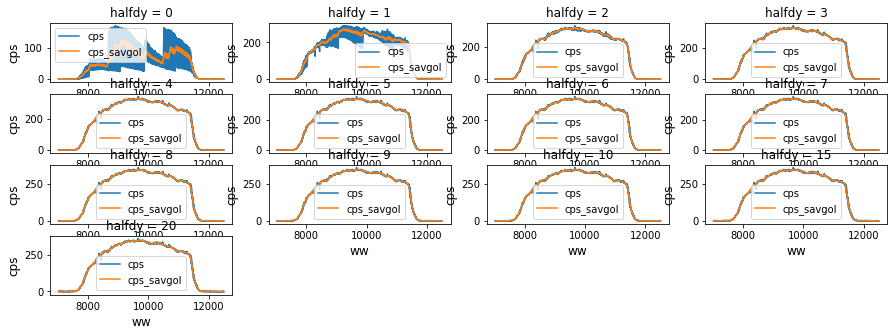

In [169]:
##########
# average
##########
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

window_length = 9
polyorder = 0

halfdy = [0,1,2,3,4,5,6,7,8,9,10,15,20]
cpslist = {}
for i,ii in enumerate(halfdy):
    cpslist[halfdy[i]] = {'ww':None,'cps':None}
    for j,jj in enumerate(crcorrfile):
        saveprefix = '{0}_GD153'.format(crcorrfile[j].split('/')[-1].split('_')[0])
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
        sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
        string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
        if j==0:
            t = pd.read_csv(string)
        else:
            tt = pd.read_csv(string)
            t = pd.concat([t,tt])
    t.sort_values(by=['ww'],inplace=True)
    cpslist[halfdy[i]] = {'ww':t.ww.values.copy(),'cps':t.cps.values.copy()}
    
for i,ii in enumerate(cpslist):
    ww = cpslist[ii]['ww']
    cps = cpslist[ii]['cps']
    t = savgol_filter(cps,window_length=window_length,polyorder=polyorder)
    cpslist[ii]['cps_savgol'] = t.copy()
    
for i,ii in enumerate(cpslist):
    ww = cpslist[ii]['ww']
    cps_savgol = cpslist[ii]['cps_savgol']
    t = interp1d(ww,cps_savgol,kind='linear',bounds_error=False,fill_value=np.nan)
    cpslist[ii]['cps_model'] = copy.deepcopy(t)
    
fig = plt.figure(figsize=(15,5))
n = len(halfdy)
ncol = 4
nrow = int(n/ncol) + 1
for i,ii in enumerate(halfdy):
    ax = fig.add_subplot(nrow,ncol,i+1)
    ax.plot(cpslist[ii]['ww'],cpslist[ii]['cps'],label='cps')
    ax.plot(cpslist[ii]['ww'],cpslist[ii]['cps_savgol'],label='cps_savgol')
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('cps',fontsize=12)
    ax.set_title('halfdy = {0}'.format(ii),fontsize=12)
    ax.legend()
    

# 3. Compute aperture correction = drzblot / crcorr

In [170]:
halfdy = [0,1,2,3,4,5,6,7,8,9,10,15,20]
drzlist = {}
for i,ii in enumerate(halfdy):
    string = './drzblot_GD153/drzblot_GD153_halfdy{0}_cps.csv'.format(halfdy[i])
    t = pd.read_csv(string)
    ww,cps = t.ww.values.copy(),t.cps.values.copy()
    crcorr_model = cpslist[ii]['cps_model'](ww)
    drzlist[halfdy[i]] = {'ww':ww.copy(),'cps':cps.copy(),'crcorr_model':crcorr_model.copy()}


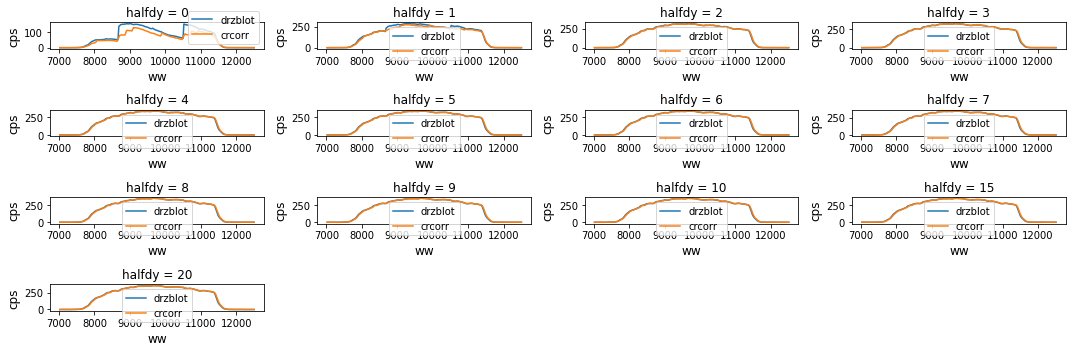

In [174]:
halfdy = [0,1,2,3,4,5,6,7,8,9,10,15,20]
fig = plt.figure(figsize=(15,5))
n = len(halfdy)
ncol = 4
nrow = int(n/ncol) + 1
for i,ii in enumerate(halfdy):
    drz_ww,drz_cps = drzlist[ii]['ww'],drzlist[ii]['cps']
    crcorr_cps = drzlist[ii]['crcorr_model']
    ax = fig.add_subplot(nrow,ncol,i+1)
    ax.plot(drz_ww,drz_cps,label='drzblot')
    ax.plot(drz_ww,crcorr_cps,label='crcorr')
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('cps',fontsize=12)
    ax.set_title('halfdy = {0}'.format(ii),fontsize=12)
    ax.legend()
fig.tight_layout()


halfdy = 0, median = 2.272E-01
halfdy = 1, median = 5.007E-02
halfdy = 2, median = 8.872E-03
halfdy = 3, median = 6.275E-03
halfdy = 4, median = 5.778E-03
halfdy = 5, median = 5.432E-03
halfdy = 6, median = 5.556E-03
halfdy = 7, median = 5.435E-03
halfdy = 8, median = 5.286E-03
halfdy = 9, median = 5.598E-03
halfdy = 10, median = 5.457E-03
halfdy = 15, median = 5.684E-03
halfdy = 20, median = 5.520E-03


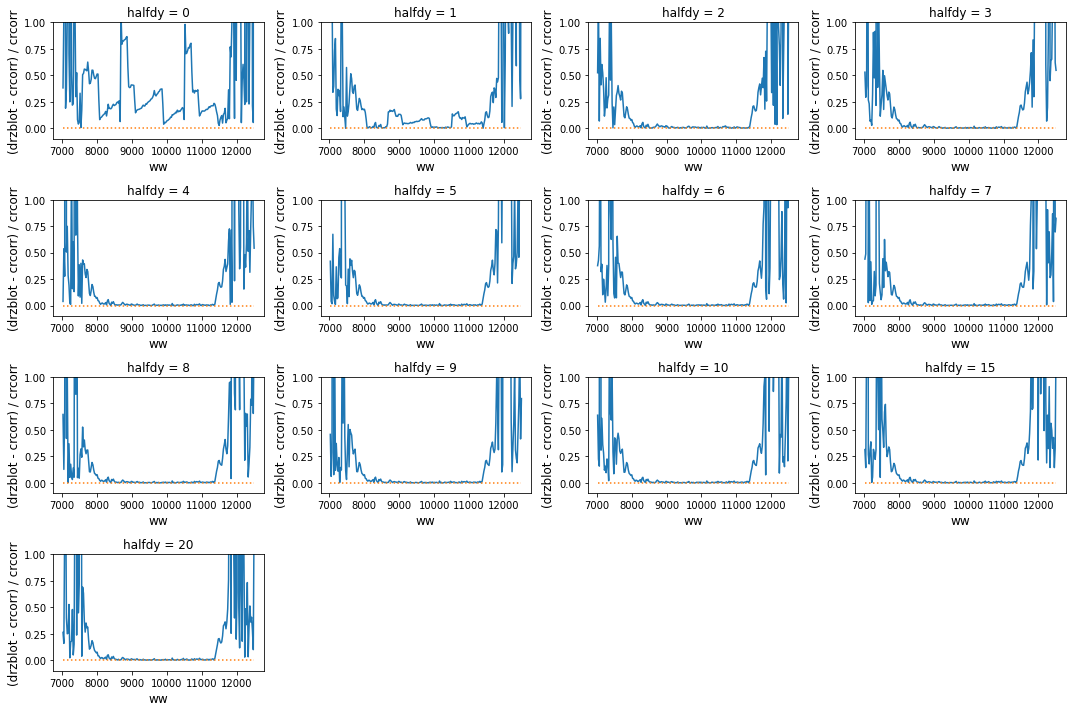

In [198]:
halfdy = [0,1,2,3,4,5,6,7,8,9,10,15,20]
fig = plt.figure(figsize=(15,10))
n = len(halfdy)
ncol = 4
nrow = int(n/ncol) + 1
for i,ii in enumerate(halfdy):
    drz_ww,drz_cps = drzlist[ii]['ww'],drzlist[ii]['cps']
    crcorr_cps = drzlist[ii]['crcorr_model']
    ax = fig.add_subplot(nrow,ncol,i+1)
    t = np.abs((drz_cps - crcorr_cps)/crcorr_cps)
    ax.plot(drz_ww,t)
    ax.plot([drz_ww.min(),drz_ww.max()],[0.,0.],':')
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('(drzblot - crcorr) / crcorr',fontsize=12)
    ax.set_title('halfdy = {0}'.format(ii),fontsize=12)
    m = np.argwhere((drz_ww >= 8000.) & (drz_ww <= 11000.)).flatten()
    print('halfdy = {0}, median = {1:.3E}'.format(ii,np.median(t[m])))
    ax.set_ylim(-0.1,1.)
fig.tight_layout()


halfdy = 0, median = 1.227E+00
halfdy = 1, median = 1.050E+00
halfdy = 2, median = 1.008E+00
halfdy = 3, median = 1.004E+00
halfdy = 4, median = 1.003E+00
halfdy = 5, median = 1.003E+00
halfdy = 6, median = 1.002E+00
halfdy = 7, median = 1.002E+00
halfdy = 8, median = 1.002E+00
halfdy = 9, median = 1.002E+00
halfdy = 10, median = 1.002E+00
halfdy = 15, median = 1.002E+00
halfdy = 20, median = 1.002E+00


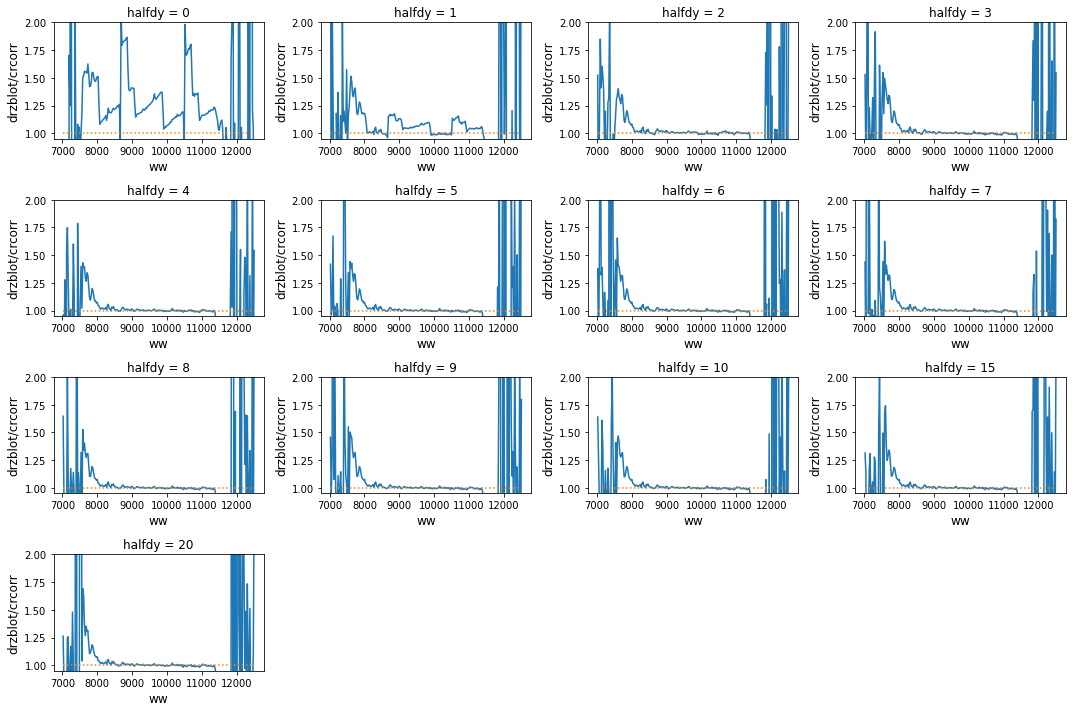

In [200]:
halfdy = [0,1,2,3,4,5,6,7,8,9,10,15,20]
fig = plt.figure(figsize=(15,10))
n = len(halfdy)
ncol = 4
nrow = int(n/ncol) + 1
for i,ii in enumerate(halfdy):
    drz_ww,drz_cps = drzlist[ii]['ww'],drzlist[ii]['cps']
    crcorr_cps = drzlist[ii]['crcorr_model']
    ax = fig.add_subplot(nrow,ncol,i+1)
    t = drz_cps/crcorr_cps
    ax.plot(drz_ww,t)
    ax.plot([drz_ww.min(),drz_ww.max()],[1.,1.],':')
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('drzblot/crcorr',fontsize=12)
    ax.set_title('halfdy = {0}'.format(ii),fontsize=12)
    ax.set_ylim(0.95,2.)
    m = np.argwhere((drz_ww >= 8000.) & (drz_ww <= 11000.)).flatten()
    print('halfdy = {0}, median = {1:.3E}'.format(ii,np.median(t[m])))
fig.tight_layout()


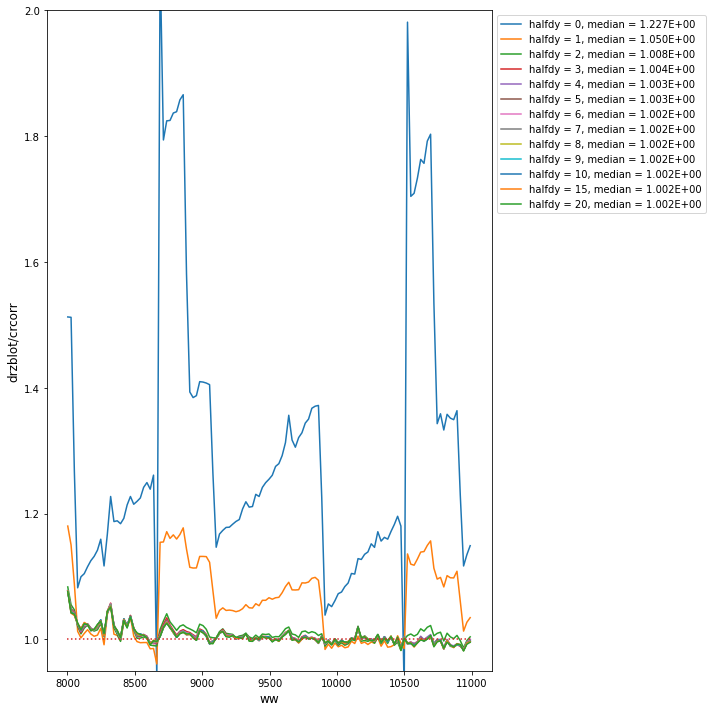

In [206]:
halfdy = [0,1,2,3,4,5,6,7,8,9,10,15,20]
plt.figure(figsize=(10,10))
for i,ii in enumerate(halfdy):
    drz_ww,drz_cps = drzlist[ii]['ww'],drzlist[ii]['cps']
    crcorr_cps = drzlist[ii]['crcorr_model']
    m = np.argwhere((drz_ww >= 8000.) & (drz_ww <= 11000.)).flatten()
    t = drz_cps/crcorr_cps
    plt.plot(drz_ww[m],t[m],label='halfdy = {0}, median = {1:.3E}'.format(ii,np.median(t[m])))
    plt.xlabel('ww',fontsize=12)
plt.plot([8000.,11000.],[1.,1.],':')
plt.ylabel('drzblot/crcorr',fontsize=12)
plt.ylim(0.95,2.)
plt.legend(bbox_to_anchor=(1., 1.))
plt.tight_layout()


# Summary
Setting halfdy >= 2 pixels, for WFC3/IR/G102, drzblot cps is approximately equal to crcorr cps.